In [87]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout


In [102]:
# Load SOC data from CSV with downsampling
def load_soc_data(file_path, downsample_factor=10):
    df = pd.read_csv(file_path)
    
    # Apply downsampling - use every Nth row
    df = df.iloc[::downsample_factor]
    
    # Assuming your CSV has columns named 'time' and 'soc'
    time = df['time (s)'].values
    soc = df['SOC'].values
    
    # Combine into a single array for the model
    data = np.column_stack((time, soc))
    
    return data

# Load and prepare data with downsampling
# Replace with your CSV file path
soc_data = load_soc_data("new_train_data.csv", downsample_factor=20)  # Use only 5% of your data

# Cap the total size to reduce memory usage
max_samples = min(10000, len(soc_data))  # Use at most 200K samples
soc_data = soc_data[:max_samples]

# Split data into train, validation, and test sets (adjust ratios as needed)
total_samples = len(soc_data)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_data = soc_data[:train_size]
val_data = soc_data[train_size:train_size+val_size]
test_data = soc_data[train_size+val_size:]

print(f"Original data downsampled by factor of 20")
print(f"Limited to {max_samples} total samples")
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

# Create trajectories with stride to reduce overlap
def create_trajectories(data, length):
    trajectories = []
    for i in range(0, len(data) - length + 1):
        trajectories.append(data[i:i+length])
    return np.array(trajectories)

# Create trajectories if your dataset is long enough
trajLength = 128  # Length of each trajectory
input_dim = 2     # Time and SOC

if len(train_data) > trajLength * 2:
    train_trajectories = create_trajectories(train_data, trajLength)
    val_trajectories = create_trajectories(val_data, trajLength)
    test_trajectories = create_trajectories(test_data, trajLength)
    
    # Adjust shapes to match model expectations
    numTraj = len(train_trajectories)
    numTraj_val = len(val_trajectories)
    
    train_data = train_trajectories  # shape: [num_trajectories, trajLength, 2]
    val_data = val_trajectories
    test_data = test_trajectories

else:
    # If data is too short, keep as is
    numTraj = 1
    numTraj_val = 1

print("After trajectory creation:")
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

# Increase batch size for faster training
batch_size = min(512, len(train_data) // 2)  # Larger batch size
# S = min(127, len(train_data) - 1)  # Prediction horizon (ensure it's less than trajectory length)
S = 50

# Update training parameters
num_batches_train = max(1, int((trajLength * numTraj) / batch_size))
num_batches_val = max(1, int((trajLength * numTraj_val) / batch_size))

print("Batch size:", batch_size)
print("Number of training batches:", num_batches_train)
print("Number of validation batches:", num_batches_val)

Original data downsampled by factor of 20
Limited to 7983 total samples
Train data shape: (5588, 2)
Validation data shape: (1197, 2)
Test data shape: (1198, 2)
After trajectory creation:
Train data shape: (5461, 128, 2)
Validation data shape: (1070, 128, 2)
Test data shape: (1071, 128, 2)
Batch size: 512
Number of training batches: 1365
Number of validation batches: 267


In [103]:

# Normalize data
min_val = tf.reduce_min(val_data, axis=0)
max_val = tf.reduce_max(val_data, axis=0)

min_train = tf.reduce_min(train_data, axis=0)
max_train = tf.reduce_max(train_data, axis=0)

min_test = tf.reduce_min(test_data, axis=0)
max_test = tf.reduce_max(test_data, axis=0)

# Normalize to [0, 1]
# Normalize per feature
# train_data = (train_data - min_train.numpy()) / (max_train.numpy() - min_train.numpy())
# val_data = (val_data - min_val.numpy()) / (max_val.numpy() - min_val.numpy())
# test_data = (test_data - min_val.numpy()) / (max_val.numpy() - min_val.numpy())

# Normalize to [0, 1] using training stats
# train_data = (train_data - min_train) / (max_train - min_train)
# val_data = (val_data - min_train) / (max_train - min_train)
# test_data = (test_data - min_train) / (max_train - min_train)
train_data = (train_data - min_train.numpy()) / (max_train.numpy() - min_train.numpy())
val_data = (val_data - min_train.numpy()) / (max_train.numpy() - min_train.numpy())
test_data = (test_data - min_train.numpy()) / (max_train.numpy() - min_train.numpy())


# Convert to TensorFlow format
# Convert to TF format
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# Wrap in tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data)).batch(batch_size)



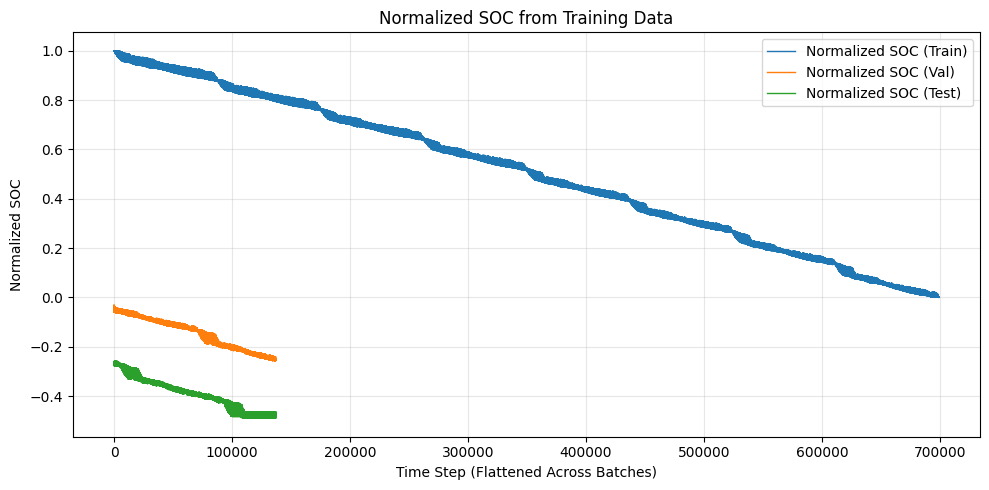

In [104]:
import matplotlib.pyplot as plt

# Extract the SOC column (index 1) across all time steps and batches
# Flatten it if needed, depending on your data shape
soc_flat = tf.reshape(train_data[:, :, 1], [-1]).numpy()  # SOC is column 1
soc_flat2 = tf.reshape(val_data[:, :, 1], [-1]).numpy()  # SOC is column 1
soc_flat3 = tf.reshape(test_data[:, :, 1], [-1]).numpy()  # SOC is column 1

# Plot normalized SOC
plt.figure(figsize=(10, 5))
plt.plot(soc_flat, label='Normalized SOC (Train)', linewidth=1)
plt.plot(soc_flat2, label='Normalized SOC (Val)', linewidth=1)
plt.plot(soc_flat3, label='Normalized SOC (Test)', linewidth=1)


plt.xlabel('Time Step (Flattened Across Batches)')
plt.ylabel('Normalized SOC')
plt.title('Normalized SOC from Training Data')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [91]:
class EncoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(500, activation="relu")
        self.dense2 = Dense(32, activation="tanh") 
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(0.1) 

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.layer_norm(x)  # Apply LayerNormalization after the dense layer
        x = self.dropout(x)
        return x

In [92]:
# Koopman Layer
class KoopmanLayer(keras.layers.Layer):
    def __init__(self, S):
        super(KoopmanLayer, self).__init__()
        self.S = S

    def build(self, input_shape):
        self.latent_dim = input_shape[-1]  # e.g. 32
        self.K = self.add_weight(
            name="Koopman_weight",
            shape=(self.latent_dim, self.latent_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, Z):
        # Z shape: (batch_size, S, latent_dim)
        batch_size = tf.shape(Z)[0]

        z0 = Z[:, 0, :]  # Initial state: shape (batch_size, latent_dim)

        # Use Koopman operator to propagate z0 for S steps
        Z2_tilde = tf.TensorArray(dtype=tf.float32, size=self.S)
        z_t = z0
        for t in range(self.S):
            Z2_tilde = Z2_tilde.write(t, z_t)
            z_t = tf.matmul(z_t, self.K)  # batch-wise matmul

        # Convert to shape (batch_size, S, latent_dim)
        Z2_tilde = tf.transpose(Z2_tilde.stack(), perm=[1, 0, 2])

        z_shift = Z[:, 1:, :]  # Ground truth: z(t+1), z(t+2), ...

        return Z, Z2_tilde, z_shift


# Koopman Model
class KoopmanModel(keras.Model):
    def __init__(self, S):
        super(KoopmanModel, self).__init__()
        self.koopman = KoopmanLayer(S)

    def call(self, z):
        z, Z2_tilde, z_shift = self.koopman(z) 
        
        #z: Latent variables of x in the lifted space
        #z2_tilde: Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
        return z,Z2_tilde,z_shift  # Pass only transformed output to the decoder

In [93]:
class DecoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(500, activation="relu")
        self.output_layer = Dense(2)  # instead of 3


    def call(self, input1, input2):
        z = input1
        z2_tilde = input2
        
        x = self.dense(z)
        x2 = self.dense(z2_tilde)

        return self.output_layer(x), self.output_layer(x2)

In [94]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, S, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = KoopmanModel(S)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde, z2 = self.koopman(z)
        x_hat, x2_tilde = self.dec(z, z2_tilde)
        return x_hat, x2_tilde


In [95]:
import time

class MyStaticModel():
    def __init__(self, input_dim, batch_size, S, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.S = S
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        
    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, model, x, x_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha1 = 1.0
        alpha2 = 1.0
        alpha3 = 1e-6
        
        # Get the shape of x2_tilde to make sure x2 matches
        tilde_shape = tf.shape(x2_tilde)
        
        # Slice the input to match the prediction shape
        # This ensures we compare the same time steps
        # x2 = x[:tilde_shape[0], 1:self.S+1]
        x2 = x[:, 1:self.S+1, :]  # Slice time steps along axis 1

        
        # recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        recon_loss = tf.reduce_mean(tf.abs(tf.subtract(x, x_hat)))
        predict_loss = tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))
        weights = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])
        
        return alpha1*recon_loss + alpha2*predict_loss + alpha3*lossL2
        
    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 10  
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        start_time_total = time.time()
        for epoch in range(epochs):
                
            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            epoch_train_min_loss = []
            epoch_train_max_loss = []
            epoch_validation_min_loss = []
            epoch_validation_max_loss = []

            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                with tf.GradientTape() as tape:
                    reconstruction, linearity= model(x_batch_train)
                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, linearity_val= model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))

        print("Total time taken: %.2fs" % (time.time() - start_time_total))



In [96]:
print(train_data.shape)  # should be like (2048, 30, 2) or similar

(5461, 128, 2)


In [97]:
koopmanAEModel = Koopman_AE_Model(S)
Training_class = MyStaticModel(input_dim, batch_size, S, num_batches_train, num_batches_val)
Training_class.fit(
    koopmanAEModel,
    x=train_data,
    y=train_data,
    validation_data=tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(batch_size),
    batch_size=batch_size
)



Start of epoch 0
Average training loss at epoch 0: 0.0063799
Epoch val loss: 0.008673009801000246
Time taken: 15.24s

Start of epoch 1
Average training loss at epoch 1: 0.0042592
Epoch val loss: 0.006331526831294713
Time taken: 28.23s

Start of epoch 2
Average training loss at epoch 2: 0.0037300
Epoch val loss: 0.005316636982035548
Time taken: 40.84s

Start of epoch 3
Average training loss at epoch 3: 0.0031925
Epoch val loss: 0.004829625511883796
Time taken: 53.60s

Start of epoch 4
Average training loss at epoch 4: 0.0030966
Epoch val loss: 0.0046352014113008305
Time taken: 66.26s

Start of epoch 5
Average training loss at epoch 5: 0.0027479
Epoch val loss: 0.004355510968840524
Time taken: 79.03s

Start of epoch 6
Average training loss at epoch 6: 0.0025520
Epoch val loss: 0.004212940230351709
Time taken: 92.06s

Start of epoch 7
Average training loss at epoch 7: 0.0024538
Epoch val loss: 0.004063541076603007
Time taken: 104.98s

Start of epoch 8
Average training loss at epoch 8: 0.

In [98]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[array([[-0.04635471,  0.03651854, -0.04595232, ..., -0.12824288,
        -0.05161837,  0.00998917],
       [-0.06796096,  0.0704376 , -0.03324629, ..., -0.0052819 ,
         0.000925  ,  0.07556016],
       [-0.00827447,  0.02410363, -0.00076171, ...,  0.01646524,
        -0.05588831, -0.00221965],
       ...,
       [ 0.12818745,  0.02815597,  0.02951033, ..., -0.02850786,
        -0.03524433,  0.01936291],
       [ 0.02003404,  0.09865794,  0.02226662, ...,  0.09488732,
         0.01636309,  0.1359885 ],
       [-0.06807556, -0.00673256,  0.0498201 , ..., -0.06175061,
         0.03277675,  0.01352437]], dtype=float32)]


In [99]:
test_data.shape

TensorShape([1071, 128, 2])

In [100]:
def visualize_soc_results(model, test_data, batch_size=256):
    """
    Visualize SOC model results comparing:
    - Actual input
    - Reconstruction
    - Predicted next steps using Koopman operator

    Args:
        model: The trained Koopman_AE_Model
        test_data: TensorFlow tensor with shape [num_trajectories, timesteps, 2]
        batch_size: Not used here, only one trajectory is shown
    """
    # Select one trajectory
    sample_idx = 0
    sample = test_data[sample_idx:sample_idx+1]  # Keep batch dimension

    # Get model outputs
    x_hat, x2_tilde = model(sample)

    # Convert to numpy and remove batch dimension
    sample_np = sample.numpy()[0]
    x_hat_np = x_hat.numpy()[0]
    x2_tilde_np = x2_tilde.numpy()[0]

    # Actual next-step (shifted input by 1 timestep)
    x2_actual = sample_np[1:]  # Remove first point
    x2_tilde_plot = x2_tilde_np[:len(x2_actual)]  # Trim prediction to match

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Plot SOC (dimension 1)
    axes[0].plot(sample_np[:, 1], label='SOC - Actual Input', color='blue')
    axes[0].plot(x_hat_np[:, 1], '--', label='SOC - Reconstruction', color='red')
    axes[0].set_title("SOC: Actual Input vs Reconstruction")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Normalized Value")
    axes[0].legend()

    # Plot next-step prediction
    axes[1].plot(range(1, len(sample_np)), x2_actual[:, 1], label='SOC - Actual Next Steps', color='blue')
    axes[1].plot(range(1, len(sample_np)), x2_tilde_plot[:, 1], '--', label='SOC - Predicted Next Steps', color='green')
    axes[1].set_title("SOC: Actual Next Steps vs Predicted")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("Normalized Value")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


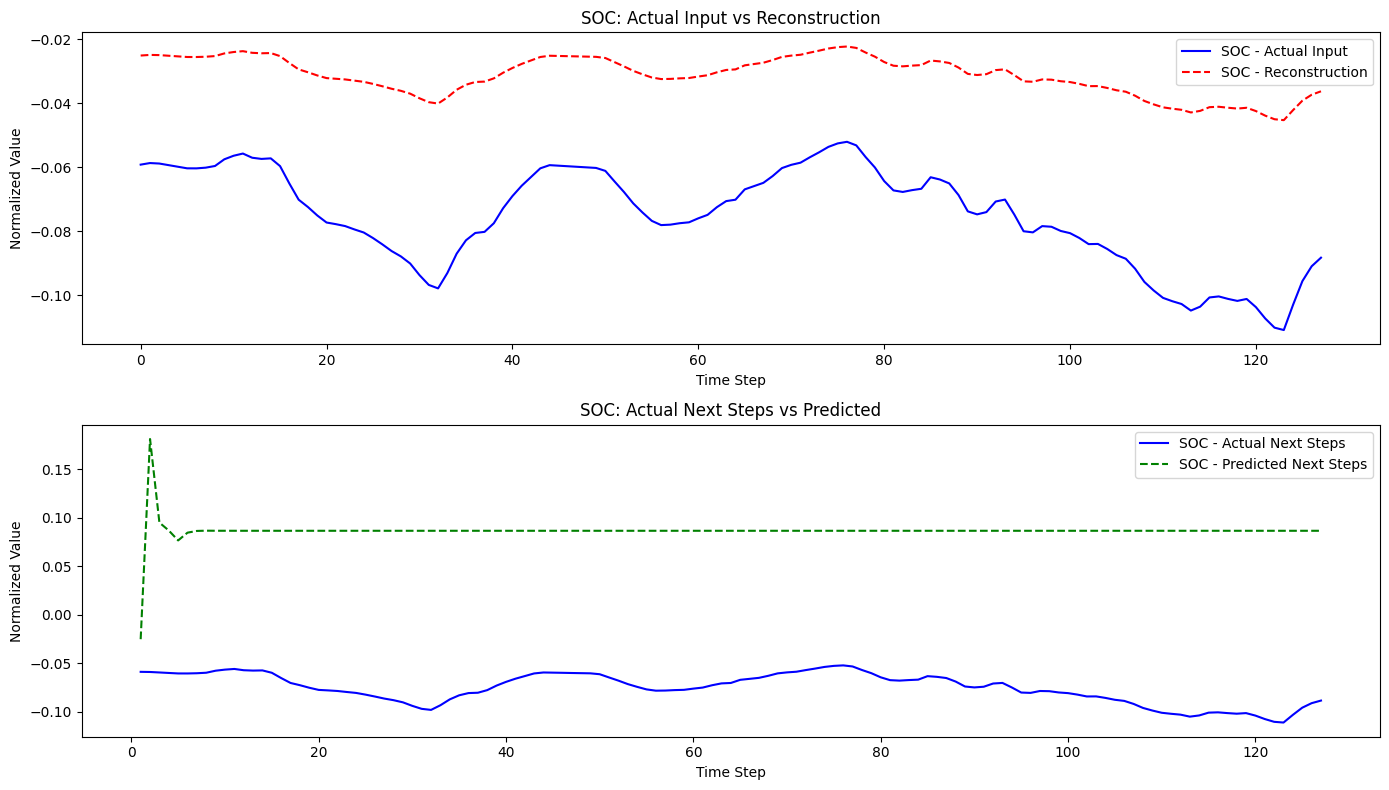

In [101]:
# Usage:
visualize_soc_results(koopmanAEModel, test_data, batch_size=1)